#Review stars classifier
The aim of this work is to create a machine learning model in order to analyze the sentiment of Italian review text as either positive (0) or negative (1) sentiment.

---

Author: Matteazzi Andrea 2010655

In [ ]:
!pip install torch
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.5 MB/s 
     |████████████████████████████████| 6.6 MB 41.5 MB/s 
     |████████████████████████████████| 596 kB 19.3 MB/s 
     |████████████████████████████████| 101 kB 1.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tqdm.notebook import tqdm
import torch
from torch import nn  
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer,  BertModel
from transformers import  get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim import Adam

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42

##DATASET

I found the dataset in https://github.com/AlessandroGianfelici/italian_reviews_dataset and it has been collected from the internet using web scraping techniques. 

In [ ]:
df  = pd.read_csv('https://raw.githubusercontent.com/AlessandroGianfelici/italian_reviews_dataset/main/raw_data.txt', sep=',')

For each data point, the dataset contains the company name (hashed for privacy reasons), the title of the review, the text of the review and the number of stars (from 1 to 5). For the scope of the project I retained 'review_text' and 'review_stars' fields.

In [ ]:
df.head()

,company_name,review_title,review_text,review_stars
0,-7078665002606529924,Eccellente e arrivato molto velocemente,Eccellente e arrivato molto velocemente,5
1,-7078665002606529924,Perfetto montato ieri .........😎,Perfetto montato ieri .........😎,5
2,-7078665002606529924,"Funziona perfettamente ,tutto ok","Funziona perfettamente ,tutto ok",5
3,-7078665002606529924,Egregi Signori,"Egregi Signori, non ho ancora potuto montare i...",4
4,-7078665002606529924,Ottimo prodotto,Ottimo prodotto,5


From the bar plot, it is possible to see how the frequency of 'review_text' with 5 and 1 corresponding 'review_stars' is much higher than the others. Hence, I decided to retain just these two groups by mapping 'review_stars'=5 (positive) in 0 and 'review_stars'=1 (negative) in 1 and doing a binary classification in positive and negative 'review_text'.

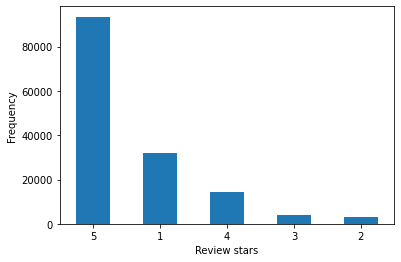

In [ ]:
df['review_stars'].value_counts().plot.bar(rot=0)
plt.xlabel('Review stars')
plt.ylabel('Frequency')
plt.show()

I decided to sample a number of 'review_stars'=5 instances equal to the number of instances 'review_stars'=1 in order to have a balanced dataset. Still the size of the dataset is big enough.

In [ ]:
df_s = []
df_s.append(df.loc[df['review_stars'] == 5].sample(n=len(df.loc[df['review_stars'] == 1]), random_state=seed, replace=False))
df_s.append(df.loc[df['review_stars'] == 1])
df_s = pd.concat(df_s)  # sampled dataframe

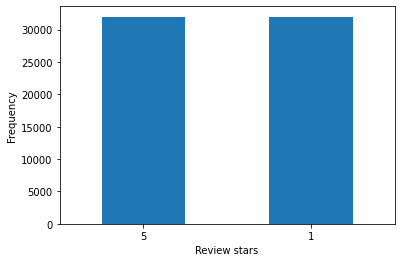

In [ ]:
df_s['review_stars'].value_counts().plot.bar(rot=0)
plt.xlabel('Review stars')
plt.ylabel('Frequency')
plt.show()

##ML MODEL

For embedding 'review_text' I decided to proceed with a pre-trained word embeddings in order to encode each sentence. I found a pre-trained Bert model in italian text https://huggingface.co/dbmdz/bert-base-italian-uncased well suited for my project.
https://arxiv.org/abs/1810.04805

In [ ]:
max_len = 512 #max 'review_text' lenght according to Bert, and a reasonable bounding for the average length of 'review_text' instances 
dim = 2 #binary classification (for being used in general with multi-class classification even with more stars I decided to stick with softmax classification instead of binary one)
batch_size = 16

In [ ]:
model_name = "dbmdz/bert-base-italian-uncased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name) #tokeniter for the Bert model

Downloading:   0%|          | 0.00/237k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

In [ ]:
class ReviewDataset(Dataset):

  def __init__(self, reviews, labels, tokenizer, max_len, dim):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.dim = dim
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
    
  def __getitem__(self, idx):
    review = str(self.reviews[idx])
    label = int(self.labels[idx])
    
    x = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      padding = 'max_length',
      truncation=True,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )

    y = torch.zeros(self.dim) #binary vector of zeros
    y[label] = 1  #one-hot encoding
    
    return {
      'review_text': review,
      'input_ids': x['input_ids'].flatten(),
      'attention_mask': x['attention_mask'].flatten(),
      'targets': y
    }

Convert 5 stars in 0 (positive) and 1 stars in 1 (negative) labels.

In [ ]:
def convert(x):
  if x==5:
    return 0
  else:
    return 1

In [ ]:
def create_data_loader(df, tokenizer, max_len, dim, batch_size):
  ds = ReviewDataset(
    reviews = df.review_text.apply(lambda x: x.lower()).to_numpy(),
    labels = df.review_stars.apply(lambda x: convert(x)).to_numpy(),
    tokenizer = tokenizer,
    dim = dim,
    max_len = max_len
  )
  
  return DataLoader(
    ds,
    batch_size=batch_size,
  )

In [ ]:
df_train, df_test = train_test_split(df_s, test_size = 0.3, random_state=seed) #split dataset in training and testing data (validation in this case was not necessary since the model architecture was pretty straighforward)


In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, max_len, dim, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, dim, batch_size)

In [ ]:
class ReviewClassifier(nn.Module):

  def __init__(self, dim):
    super().__init__()
    self.bert = BertModel.from_pretrained(model_name, return_dict=False)
    for name, param in list(self.bert.named_parameters())[:-2]:   
        print('I will be frozen: {}'.format(name)) 
        param.requires_grad = False

    self.dense_block = nn.Sequential(
            nn.Dropout(.25),
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, dim))
    self.output = nn.Softmax(dim=1)

  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask)

    dense = self.dense_block(pooled_output)
    return self.output(dense)

For avoiding overfitting and since a limited amount of data and computational resources, I decided to just fine-tuning the last 2 layers of the pre-trained Bert model (by freezing all the others). On top of Bert I added a dropout layers as source of regularization and two dense layers. The output is a vector of dim=2 implementing probability distribution over positive and negative sentiment.

In [ ]:
model = ReviewClassifier(dim)
model = model.to(device)

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


I will be frozen: embeddings.word_embeddings.weight
I will be frozen: embeddings.position_embeddings.weight
I will be frozen: embeddings.token_type_embeddings.weight
I will be frozen: embeddings.LayerNorm.weight
I will be frozen: embeddings.LayerNorm.bias
I will be frozen: encoder.layer.0.attention.self.query.weight
I will be frozen: encoder.layer.0.attention.self.query.bias
I will be frozen: encoder.layer.0.attention.self.key.weight
I will be frozen: encoder.layer.0.attention.self.key.bias
I will be frozen: encoder.layer.0.attention.self.value.weight
I will be frozen: encoder.layer.0.attention.self.value.bias
I will be frozen: encoder.layer.0.attention.output.dense.weight
I will be frozen: encoder.layer.0.attention.output.dense.bias
I will be frozen: encoder.layer.0.attention.output.LayerNorm.weight
I will be frozen: encoder.layer.0.attention.output.LayerNorm.bias
I will be frozen: encoder.layer.0.intermediate.dense.weight
I will be frozen: encoder.layer.0.intermediate.dense.bias
I wi

In [ ]:
print(model)

ReviewClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
# optimizer, scheduler and loss function

epochs = 5

optimizer = Adam(model.parameters(), lr=1e-03)
loss_function = nn.CrossEntropyLoss()
num_training_steps = epochs * len(train_data_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
def train_model(
  model,
  data_loader,
  loss_function,
  optimizer,
  lr_scheduler,
  device,
  epochs
):
  history = []
  model = model.train()
  for epoch in tqdm(range(epochs)):
    loss_batch = 0
    n_batch = 0
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      preds = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      preds = preds.squeeze(dim=1)
      loss = loss_function(preds, targets)

      n_batch += 1
      loss_batch += loss
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
    history.append(loss_batch/n_batch)  #average loss per epoch
  return history

In [ ]:

history = train_model(
    model,
    train_data_loader,    
    loss_function, 
    optimizer, 
    lr_scheduler,
    device,
    epochs 
    )

  0%|          | 0/5 [00:00<?, ?it/s]

The training loss is decreasing over epochs, meaning that the model is learning.

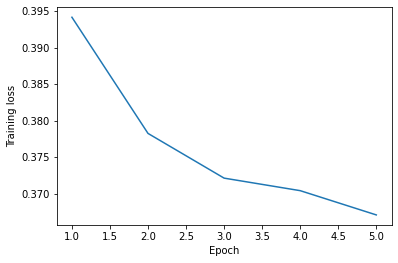

In [ ]:
plt.plot(range(1, epochs+1), list(map(lambda x: float(x.cpu().detach().numpy()),history)))
plt.ylabel('Training loss')
plt.xlabel("Epoch")

plt.show()

##EVALUATION AND CONCLUSION

In [ ]:
def eval_model(model, data_loader, device):
  model = model.eval()

  preds = []
  targets = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["targets"].to(device)

      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      pred = torch.argmax(output, dim=1).cpu()
      target = torch.argmax(target, dim=1).cpu()

      preds.append(pred)
      targets.append(target)

  preds = np.concatenate(preds)
  targets = np.concatenate(targets)

  class_names = ['positive', 'negative']  #0:positive 1:negative

  print(classification_report(targets, preds, target_names=class_names))

Evaluate the model over training data.

In [ ]:
eval_model(
    model,
    train_data_loader,
    device)

              precision    recall  f1-score   support

    positive       0.96      0.95      0.96     22404
    negative       0.95      0.96      0.96     22386

    accuracy                           0.96     44790
   macro avg       0.96      0.96      0.96     44790
weighted avg       0.96      0.96      0.96     44790



Evaluate the model over test data. The f1-score and the accuracy are identical to the performance over the training set and are pretty high.

In [ ]:
eval_model(
    model,
    test_data_loader,
    device)

              precision    recall  f1-score   support

    positive       0.96      0.95      0.95      9589
    negative       0.95      0.96      0.96      9607

    accuracy                           0.96     19196
   macro avg       0.96      0.96      0.96     19196
weighted avg       0.96      0.96      0.96     19196



From the obtained results, it is possible to conclude that the model accomplishes the task and is then able to classify the 'review_text' as either positive or negative sentiment. 
The use of pre-trained Bert model over italian text is crucial for this task, since the available italian dataset and the computational resources are not enough to train a model from scratch.